In [24]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = "svg"

# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting, residual_calc02
from my_progs.catalog.pos_diff import nor_sep_calc, pos_diff_calc
from my_progs.catalog.pos_err import pos_err_calc
from my_progs.catalog.write_output import print_vsh1_corr, print_vsh2_corr
from my_progs.stat_func.rms_calc import rms_calc

In [25]:
# Read Gaia DR2 IERS quasar data
from my_progs.catalog.read_gaia import read_dr2_iers

gaiadr2 = read_dr2_iers()

# A selection on the G magnitude
bgt_mask = (gaiadr2["phot_g_mean_mag"] >= 18.7)
gaiadr2 = gaiadr2[bgt_mask]
gaiadr2.filled()

# Read ICRF2 catalog
from my_progs.catalog.read_icrf import read_icrf2
icrf2 = read_icrf2()

# Crossmatch among these three catalogs
common_source = join(icrf2, gaiadr2, keys="iers_name", table_names=["icrf2", "gaiadr2"]) 

In [26]:
# The positonal offset for common sources between GaiaDR2 and ICRF2.
[dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov,
 ang_sep, X_a, X_d, X] = pos_diff_calc(
    common_source["ra_icrf2"], common_source["ra_err_icrf2"],
    common_source["dec_icrf2"], common_source["dec_err_icrf2"],
    common_source["ra_dec_corr_icrf2"],
    common_source["ra_gaiadr2"], common_source["ra_err_gaiadr2"],
    common_source["dec_gaiadr2"], common_source["dec_err_gaiadr2"],
    common_source["ra_dec_corr_gaiadr2"])

common_source.add_columns(
    [dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d, X],
    names=["dra", "ddec", "dra_err", "ddec_err", "dra_ddec_cov",
           "ang_sep", "nor_dra",  "nor_ddec", "nor_sep"])

common_source["dra"].unit = u.mas
common_source["ddec"].unit = u.mas
common_source["dra_err"].unit = u.mas

In [27]:
common_source

icrf_name,ivs_name,iers_name,ra_icrf2,dec_icrf2,type,ra_err_icrf2,dec_err_icrf2,ra_dec_corr_icrf2,pos_err_icrf2,mean_obs,beg_obs,end_obs,nb_sess,nb_del,source_id,ra_gaiadr2,ra_err_gaiadr2,dec_gaiadr2,dec_err_gaiadr2,pos_err_gaiadr2,parallax,parallax_err,pmra,pmra_err,pmdec,pmdec_err,ra_dec_corr_gaiadr2,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_dra,nor_ddec,nor_sep
,,,deg,deg,,mas,mas,,mas,,,,,,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,mag,mag,mag,mas,mas,mas,mas,mas,deg,deg,deg,deg
str16,str8,str8,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
J000318.6-192722,0000-197,0000-197,0.8278126013333333,-19.456209681833332,V,0.4859687733303084,0.9445999999999999,-0.224,0.9528939533621429,50650.0,50632.3,50688.3,2,76,2365855384650325376,0.8278123681512258,0.2387757610163772,-19.456209949035525,0.1922200644996743,0.24241216451703895,-0.45544305828221626,0.3185109654739551,0.6116734571782345,0.5735415853774198,0.37085954108422414,0.39878223344506625,0.13461179,0.052950118,0.35212186,-0.022328816,-0.097155325,-0.019389542,0.2804625,-0.1926077,-0.35069835,0.24758662,19.193932,19.635006,18.525171,0.7915196001173063,0.9619278941386256,0.5414605366054989,0.9639593939561244,-0.09664798376771899,1.245716079567022,1.4618232476912665,0.9978925462729695,1.9502179928220507
J000315.9-194150,0000-199,0000-199,0.8164555134166667,-19.697332749361113,V,4.6366314167931675,13.643499999999998,-0.943,14.33480339351269,54088.1,54088.1,54088.1,1,11,2365814049884978048,0.8164555380378795,0.31214484752059934,-19.697333393384483,0.20132065134575663,0.31218319151974,-0.24976210176238237,0.36241695927078477,0.6167410883691041,0.5467370543754372,-0.20622857222487195,0.4638258235243829,0.01857697,0.46789265,0.3675997,-0.17307134,-0.20771366,0.066310346,0.5528602,-0.10075016,-0.40074503,0.2787808,19.058247,19.314455,18.64363,-0.0834499188616225,2.3184841310808224,4.647126563913132,13.644985242009543,-59.65290013393942,2.319985464400932,-0.01795731571195968,0.16991474083407446,0.45161150569105285
J000416.1+461517,0001+459,0001+459,1.0671985645,46.254991665472225,V,0.31664958249475456,0.6327999999999999,0.096,0.6337693172688701,50306.3,50306.3,50306.3,1,75,387054966590038656,1.0671982239853723,0.7718284266351787,46.25499167308568,0.6969576827283192,0.777985787941841,-0.029368229696100832,1.0984495193905532,0.9944652987116404,1.2381622163997819,0.4579145221304079,0.9951609005577559,-0.06277916,0.42371804,-0.60506684,0.19084497,0.07386451,0.025139727,-0.6068582,-0.4637956,0.30770168,-0.2570573,20.491125,20.788141,19.799097,0.847615968540496,-0.02740842433013313,0.834257800836311,0.9413744480885532,-0.014534820465923252,0.8480589907837213,1.0160120381143503,-0.029115326410001384,1.0160643805420515
J000404.9-114858,0001-120,0001-120,1.0204791624583331,-11.816218260277779,V,0.1286155636323102,0.27809999999999996,-0.072,0.27829570699166345,51045.0,50576.2,53134.5,3,109,2421598528234887680,1.0204794846922574,0.3102386470908995,-11.816218379326092,0.29214212886423696,0.33998919727933147,0.06584825341243254,0.3640494710474267,0.049237658462576495,0.7606129274645607,0.44519648557145636,0.7265389349874076,0.26688337,0.16208343,0.33467895,0.089694664,-0.13309994,0.2532729,0.7076963,-0.11914465,-0.22260411,0.5138607,19.32226,19.66084,18.616665,-1.135460213253949,0.42857392514861203,0.3358421971063918,0.4033443112990791,0.021613353468330005,1.2136496632883773,-3.380933733274278,1.0625510590896252,3.7502196823647203
J000435.6-473619,0002-478,0

In [28]:
# Seperate the sources into the "defining sources" and "other sources".
# Defining sources
mask_def = (common_source["type"] == "D")
com_def = common_source[mask_def]

# VCS sources
mask_vcs = (common_source["type"] == "V")
com_vcs = common_source[mask_vcs]

# Non-VCS sources
mask_nvc =  (common_source["type"] == "N")
com_nvc = common_source[mask_nvc]

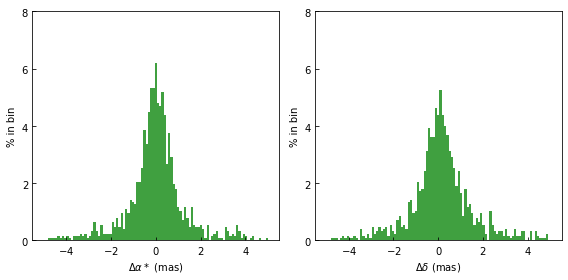

In [29]:
# Difference in RA and decl.
bins_array = np.linspace(-5, 5, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dRA, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(dDC, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

ax0.set_ylim([0, 8])
ax1.set_ylim([0, 8])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

In [30]:
std_ra = np.std(dRA)
std_dec = np.std(dDC)
_, wrms_ra, _ = rms_calc(dRA, dRA_err)
_, wrms_dec, _ = rms_calc(dDC, dDC_err)

std_ra, std_dec, wrms_ra, wrms_dec

(3.1095322271617465, 5.144455071006855, 1.534068373695482, 1.6515221235307769)

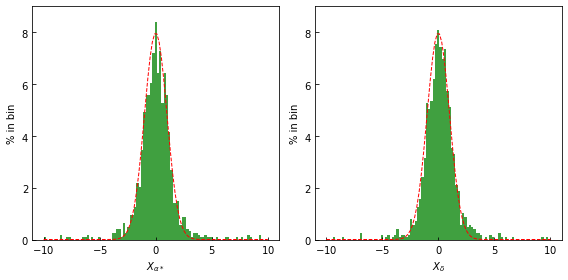

In [31]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(X_a, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(X_d, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylim([0, 9])
ax1.set_ylim([0, 9])

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 10, 2))
ax1.set_yticks(np.arange(0, 10, 2))

fig.tight_layout()
plt.show()

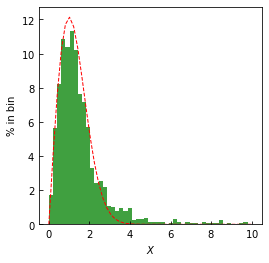

In [32]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X) * 100. / X.size

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(X, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlabel("$X$")
ax.set_ylabel("% in bin")

plt.show()

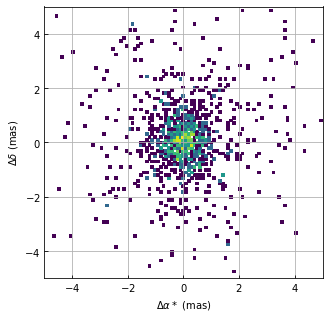

In [33]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(5, 5))

bins = np.linspace(-5, 5, 100)

# We can increase the number of bins on each axis
ax.hist2d(dRA, dDC, bins, norm=colors.LogNorm())

ax.set_xlabel("$\Delta\\alpha*$ (mas)")
ax.set_ylabel("$\Delta\\delta$ (mas)")

ax.grid(True)

plt.show()

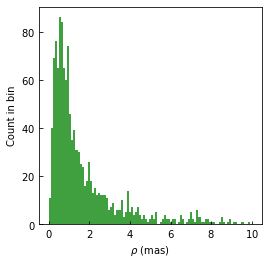

In [34]:
# Distribution of angular separation
bins_array = np.linspace(0, 10, 100)

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(ang_sep, bins_array, facecolor="g", alpha=0.75)

ax.set_xlabel("$\\rho$ (mas)")
ax.set_ylabel("Count in bin")

plt.show()

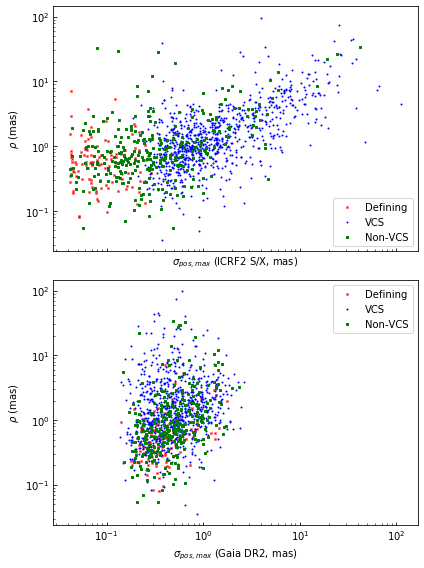

In [35]:
# Angular position difference vs. positional uncertainty
fig, (ax0, ax1) = plt.subplots(figsize=(6, 8), nrows=2, sharex=True)

ax0.plot(com_def["pos_err_icrf2"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")
ax1.plot(com_def["pos_err_gaiadr2"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")

ax0.plot(com_vcs["pos_err_icrf2"],
         com_vcs["ang_sep"], "b.", ms=2, label="VCS")
ax1.plot(com_vcs["pos_err_gaiadr2"],
         com_vcs["ang_sep"], "b.", ms=2, label="VCS")

ax0.plot(com_nvc["pos_err_icrf2"],
         com_nvc["ang_sep"], "gs", ms=2, label="Non-VCS")
ax1.plot(com_nvc["pos_err_gaiadr2"],
         com_nvc["ang_sep"], "gs", ms=2, label="Non-VCS")

ax0.set_xscale("log")
ax0.set_yscale("log")
ax1.set_xscale("log")
ax1.set_yscale("log")

ax0.set_xlabel("$\sigma_{pos,max}$ (ICRF2 S/X, mas)")
ax0.set_ylabel("$\\rho$ (mas)")
ax1.set_xlabel("$\sigma_{pos,max}$ (Gaia DR2, mas)")
ax1.set_ylabel("$\\rho$ (mas)")


ax0.legend()
ax1.legend()

fig.tight_layout()
plt.show()

Then I investigate the systematics through the 16-parameters transformation.

In [36]:
# Try with all the sources
# Transform columns into np.array
dra = np.array(common_source["dra"])
ddec = np.array(common_source["ddec"])
dra_err = np.array(common_source["dra_err"])
ddec_err = np.array(common_source["ddec_err"])
ra_rad = np.array(common_source["ra_icrf2"].to(u.radian))
dec_rad = np.array(common_source["dec_icrf2"].to(u.radian))
dra_ddec_cov = np.array(common_source["dra_ddec_cov"])

# Transformation parameters
# l_max = 1
w1_all, sig1_all, corrcoef1_all = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_all, sig2_all, corrcoef2_all = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_all * 1.e3
sig1 = sig1_all * 1.e3
w2 = w2_all * 1.e3
sig2 = sig2_all * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_all, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_all, deci_digit=1, included_one=False)

Estimates (  1275 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1   -15 +/-  58   +83 +/-  57   -37 +/-  51     +80 +/-  53   +17 +/-  54  +129 +/-  56
l_max=2    +9 +/-  59   +92 +/-  59   -34 +/-  52     +68 +/-  56   +51 +/-  56  +142 +/-  60
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       24    34
            EI22      -70    34
            ER21       -4    71
            EI21     -106    73
             E20      -75    67
            MR22       -2    38
            MI22        9    36
            MR21      141    75
     

In [37]:
# The last step is to save the 16 transformation parameters for further use.

vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf2_gaiadr2_fnt_vsh02_all.log",
             format="ascii", overwrite=True)

For a `clean` sample, I re-estimate the parameters.

In [47]:
# Remove the outlier (consider the normalized separation)
N = len(common_source)
X0 = np.sqrt(np.log(N) * 2)
# X0 = 3.41

print("There are %d sources.\n"
      "When X >= %.2f, the number of the outlier is smaller than 1." % (N, X0))

mask = ((common_source["nor_sep"] <= X0)
        & (common_source["ang_sep"] < 10))

# Table of a clean sample
com_clean = common_source[mask]
N1 = len(com_clean)
print("After elimination, there are %d sources in the clean sample." % N1)
print("The outlier rate is %.0f%%." % ((N-N1)/N*100))

There are 1275 sources.
When X >= 3.78, the number of the outlier is smaller than 1.
After elimination, there are 1162 sources in the clean sample.
The outlier rate is 9%.


In [39]:
# Transform columns into np.array
dra = np.array(com_clean["dra"])
ddec = np.array(com_clean["ddec"])
dra_err = np.array(com_clean["dra_err"])
ddec_err = np.array(com_clean["ddec_err"])
ra_rad = np.array(com_clean["ra_icrf2"].to(u.radian))
dec_rad = np.array(com_clean["dec_icrf2"].to(u.radian))
dra_ddec_cov = np.array(com_clean["dra_ddec_cov"])

In [40]:
# Transformation parameters
# l_max = 1
w1_cln, sig1_cln, corrcoef1_cln = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_cln, sig2_cln, corrcoef2_cln = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_cln * 1.e3
sig1 = sig1_cln * 1.e3
w2 = w2_cln * 1.e3
sig2 = sig2_cln * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_cln, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_cln, deci_digit=1, included_one=False)

Estimates (  1162 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1   +18 +/-  21   -39 +/-  21   +16 +/-  19     +22 +/-  20    +8 +/-  20   +80 +/-  21
l_max=2   +26 +/-  22   -38 +/-  22   +25 +/-  19     +26 +/-  21   +15 +/-  21   +86 +/-  22
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       19    13
            EI22       -2    12
            ER21        2    26
            EI21       -8    27
             E20      -31    25
            MR22       -3    14
            MI22      -12    13
            MR21       62    28
     

Save the results for future use.

In [41]:
# The last step is to save the 16 transformation parameters for further use.

vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf2_gaiadr2_fnt_vsh02.log",
             format="ascii", overwrite=True)

Then I check the residuals of positional offsets.

In [42]:
# Remove the systematics
RA = np.array(common_source["ra_icrf2"].to(u.radian))
DE = np.array(common_source["dec_icrf2"].to(u.radian))

# dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_cln)
dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_all)

# Now re-calculate the normalized difference
ang_sep_ns, Xa_ns, Xd_ns, X_ns = nor_sep_calc(
    dra_ns, dRA_err, ddec_ns, dDC_err, dRA_dDC_cov/dRA_err/dDC_err)

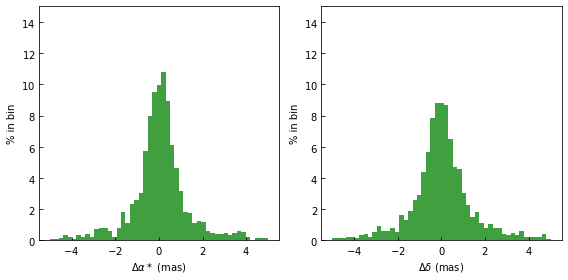

In [43]:
# Difference in RA and decl.
bins_array = np.linspace(-5, 5, 50)
weights = np.ones_like(dra_ns) * 100. / dra_ns.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dra_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(ddec_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 15, 2))
ax1.set_yticks(np.arange(0, 15, 2))

ax0.set_ylim([0, 15])
ax1.set_ylim([0, 15])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

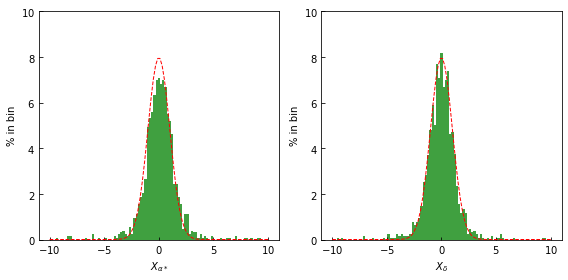

In [44]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(Xa_ns) * 100. / Xa_ns.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(Xa_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(Xd_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

fig.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

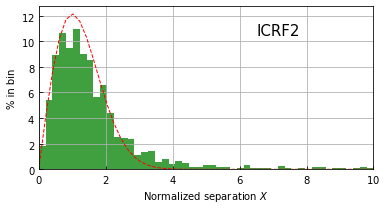

In [45]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X_ns) * 100. / X_ns.size

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(X_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.text(6.5, 10.5, "ICRF2", fontsize=15)

ax.set_xlim([0, 10])
ax.set_xlabel("Normalized separation $X$")
ax.set_ylabel("% in bin")
ax.grid()

plt.savefig("../plots/x_icrf2_gaiadr2_fnt.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


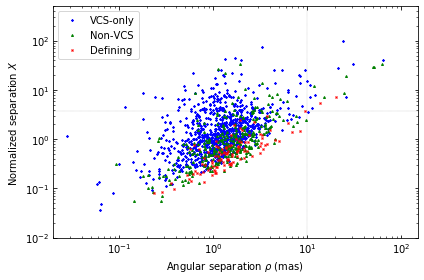

In [46]:
# Angular separation vs. normalized separation
fig, ax = plt.subplots()

ax.plot(com_vcs["nor_sep"], com_vcs["ang_sep"],
         "b*", ms=2, label="VCS-only")
ax.plot(com_nvc["nor_sep"], com_nvc["ang_sep"],
         "g^", ms=2, label="Non-VCS")
ax.plot(com_def["nor_sep"], com_def["ang_sep"],
         "rx", ms=2, label="Defining")

ax.vlines(10, 0.01, 500, colors="k", linestyles="dashed", lw=0.1)
ax.hlines(X0, 0.02, 150, colors="k", linestyles="dashed", lw=0.1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel("Normalized separation $X$")
ax.set_xlabel("Angular separation $\\rho$ (mas)")

ax.set_xlim([0.02, 150])
ax.set_ylim([0.01, 500])
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(loc="upper left")
fig.tight_layout()

plt.savefig("../plots/separation_icrf2_gaiadr2_fnt.eps")